In [ ]:
from zipfile import ZipFile
filename="MobileNet.zip"

#with ZipFile(filename, 'r') as zip:
  #zip.extractall()
  #print("done")

done


In [ ]:
import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from google.colab import files

base_dir = '/content/MobileNet/'
classes = ['Joaquim', 'Pontes', 'Raul', 'Vale']
dataset_split_percentage = 0.8
epochs = 60
batch_size = 64
IMG_SHAPE = 224


for cl in classes:
    img_path = os.path.join(base_dir, cl)
    images = glob.glob(img_path + '/*.jpg')
    print("{}: {} Images".format(cl, len(images)))
    num_train = int(round(len(images) * dataset_split_percentage))
    train, val = images[:num_train], images[num_train:]

    for t in train:
        if not os.path.exists(os.path.join(base_dir, 'train', cl)):
            os.makedirs(os.path.join(base_dir, 'train', cl))
        bn=os.path.basename(t)
        if not os.path.exists(os.path.join(base_dir, 'train', cl, bn)):
            shutil.move(t, os.path.join(base_dir, 'train', cl))

    for v in val:
        if not os.path.exists(os.path.join(base_dir, 'val', cl)):
            os.makedirs(os.path.join(base_dir, 'val', cl))
        bn = os.path.basename(v)
        if not os.path.exists(os.path.join(base_dir, 'val', cl, bn)):
            shutil.move(v, os.path.join(base_dir, 'val', cl))

print("training images:", round(len(images)*dataset_split_percentage))
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')


##  Model
image_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True,
    zoom_range=0.5)
train_data_gen = image_gen_train.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_SHAPE,IMG_SHAPE),
    class_mode='sparse')

image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(
    batch_size=batch_size,
    directory=val_dir,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    class_mode='sparse')

modelMobilenet = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet')
#modelMobilenet.summary()
modelMobilenet.trainable = False

base_output = modelMobilenet.layers[-2].output 
new_output = tf.keras.layers.Dense(4, activation="softmax")(base_output)
model = tf.keras.models.Model(inputs=modelMobilenet.inputs, outputs=new_output)
model.summary()

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])


history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size))) )

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig("plots_"+str(epochs)+"epoch.jpg")
files.download("plots_"+str(epochs)+"epoch.jpg")
plt.show()

In [ ]:
image_gen_test = ImageDataGenerator(rescale=1./255)
test_data_gen = image_gen_test.flow_from_directory(
    batch_size=batch_size,
    directory=val_dir,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    class_mode='sparse')
X_test, y_test=test_data_gen.next()

Y_predict = model.predict(X_test)

#show
Y_predict[0]

In [ ]:
Y_predicted_label = np.argmax(Y_predict, axis=-1)
Y_predicted_label

In [ ]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, Y_predicted_label, labels=[0, 1, 2, 3])
print("Confusion Matrix:")
print(cm)

prfs = metrics.precision_recall_fscore_support(y_test, Y_predicted_label)
print("Precision Recall F-score Support:")
print(prfs)

accuracy = metrics.accuracy_score(y_test, Y_predicted_label)
print("Accuracy:")
print(accuracy)

cr = metrics.classification_report(y_test, Y_predicted_label)
print("Classification Report:")
print(cr)

Confusion Matrix:
[[25  0  2  0]
 [ 0 18  0  1]
 [ 1  0 22  0]
 [ 0  0  0 31]]
Precision Recall F-score Support:
(array([0.96, 1.  , 0.92, 0.97]), array([0.93, 0.95, 0.96, 1.  ]), array([0.94, 0.97, 0.94, 0.98]), array([27, 19, 23, 31]))
Accuracy:
0.96
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94        27
         1.0       1.00      0.95      0.97        19
         2.0       0.92      0.96      0.94        23
         3.0       0.97      1.00      0.98        31

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100




Confusion matrix, without normalization
[[25  0  2  0]
 [ 0 18  0  1]
 [ 1  0 22  0]
 [ 0  0  0 31]]



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

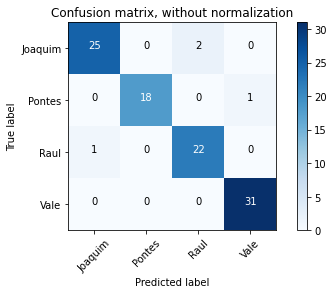


Normalized confusion matrix
[[ 92.59   0.     7.41   0.  ]
 [  0.    94.74   0.     5.26]
 [  4.35   0.    95.65   0.  ]
 [  0.     0.     0.   100.  ]]



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

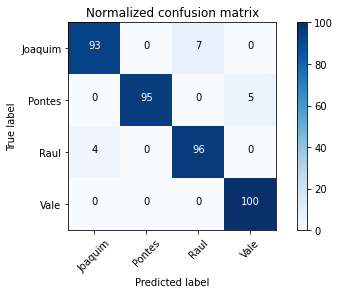

In [ ]:
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  saveName=""
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      cm = cm * 100
      print("\nNormalized confusion matrix")
      saveName=str(epochs)+"epoch_ncm"
  else:
      print('\nConfusion matrix, without normalization')
      saveName=str(epochs)+"epoch_cm"
  print(cm)
  print ()

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.0f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.savefig("plots_"+saveName+".jpg")
  files.download("plots_"+saveName+".jpg")
  plt.show()
  

# Compute confusion matrix
predictions = model.predict(X_test)
class_names = classes

y_pred = np.argmax(predictions, axis=1)
y_pred = tf.keras.utils.to_categorical(y_pred, num_classes=4, dtype="float32")
cnf_matrix = confusion_matrix(y_test, y_pred.argmax(axis=1))
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

In [ ]:
#SAVE MODEL
model.save("MobileNet_Caras_"+str(epochs)+"epoch.h5")
files.download("MobileNet_Caras_"+str(epochs)+"epoch.h5")